# Block encoding Demo

In [14]:
import numpy as np
import math
from math import log2, ceil
from qiskit import QuantumCircuit, QuantumRegister, transpile, ClassicalRegister
from qiskit_aer import Aer
from qiskit.circuit.library import *
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import time
from qiskit.visualization import circuit_drawer


### Block encoding a Banded Circulant Matrix

This matrix structure is obtained after discretizing a $1D$ Poisson equation (commonly seen in fields like CFD, Electromagnetics, etc). The below quantum circuit can be used to block encode a banded circulant matrix. Iis based on the construction provided in [this paper](https://arxiv.org/abs/2203.10236). 

<div style="text-align:center;">
  <img src="Images/Full_circuit.png" style="max-width:900px; width:50%; height:auto; display:block; margin:0 auto 16px;" />
  <div style="display:flex; justify-content:center; gap:8px;">
    <img src="Images/O_A_circuit.png" style="width:32%; max-width:320px; height:auto;" />
    <img src="Images/O_C_circuit.png" style="width:32%; max-width:320px; height:auto;" />
    <img src="Images/shift.png" style="width:40%; max-width:450px; height:auto;" />
  </div>
</div>

Matrix A:
[[0.1 0.2 0.  0.  0.  0.  0.  0.3]
 [0.3 0.1 0.2 0.  0.  0.  0.  0. ]
 [0.  0.3 0.1 0.2 0.  0.  0.  0. ]
 [0.  0.  0.3 0.1 0.2 0.  0.  0. ]
 [0.  0.  0.  0.3 0.1 0.2 0.  0. ]
 [0.  0.  0.  0.  0.3 0.1 0.2 0. ]
 [0.  0.  0.  0.  0.  0.3 0.1 0.2]
 [0.2 0.  0.  0.  0.  0.  0.3 0.1]]


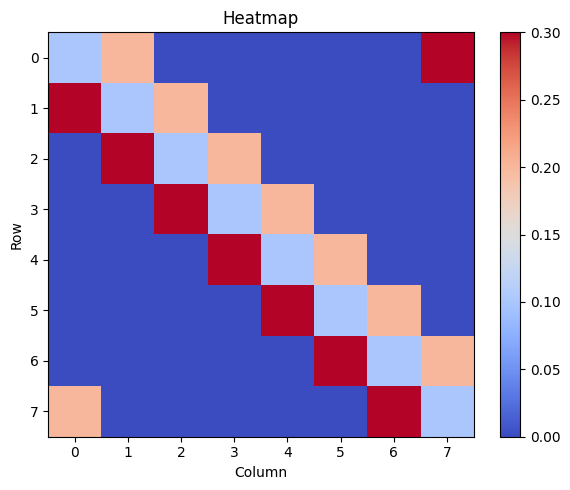

In [9]:
def banded_circulant_matrix(N, alpha, beta, gamma):
    """
    Generate a banded circulant matrix A of size N x N with parameters alpha, beta, gamma.
    """
    # Initialize an N x N zero matrix
    A = np.zeros((N, N))

    # Fill the diagonal with alpha
    np.fill_diagonal(A, alpha)
    
    # Fill the first upper diagonal with gamma
    np.fill_diagonal(A[0:N-1, 1:N], gamma)

    # Fill the first lower diagonal with beta
    np.fill_diagonal(A[1:N, 0:N-1], beta)

    # Set the wrap-around elements for banded circulant nature
    A[0, N-1] = beta  # Top-right corner
    A[N-1, 0] = gamma  # Bottom-left corner

    return A

N = 8
alpha = 0.1
beta = 0.3
gamma = 0.2

A = banded_circulant_matrix(N, alpha, beta, gamma)
print("Matrix A:")
print(A)

def plot_heatmap(A, cmap='coolwarm', annot=False, fmt='.2f', figsize=(6,5), vmin=None, vmax=None):
    """
    Plot a heatmap for 2D array `A`. Uses seaborn if available, otherwise matplotlib imshow
    Parameters:",
      - A: 2D numpy array or array-like",
      - cmap: colormap name",
      - annot: show cell values (only with seaborn)",
      - fmt: number format for annotations",
      - figsize: (width, height) in inches",
      - vmin/vmax: color limits (optional)",
    """""
    A = np.asarray(A)
    plt.figure(figsize=figsize)

    im = plt.imshow(A, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    if annot:
    # simple annotations using text
        nrows, ncols = A.shape
        for i in range(nrows):
            for j in range(ncols):
                plt.text(j, i, format(A[i, j], fmt), ha='center', va='center', color='w', fontsize=8)
    plt.title('Heatmap')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.tight_layout()
    plt.show()

plot_heatmap(A, annot=False)


In [10]:
# list containing theta_0, theta_1, theta_2. These angles are related to the values as matrix as given below
theta_raw = [
    2 * np.arccos(alpha - 1),
    2 * np.arccos(beta),
    2 * np.arccos(gamma),
]

num_angles = 2 ** ceil(log2(len(theta_raw)))
num_controls = int(log2(num_angles))

qreg_j   = QuantumRegister(int(log2(N)))
qreg_l   = QuantumRegister(num_controls)
qreg_anc = QuantumRegister(1) 
qc = QuantumCircuit(qreg_j,qreg_l,qreg_anc)


def apply_OA(qc, qreg_l, qreg_anc, theta_raw):
    qc.append(RYGate(theta_raw[0]).control(2, ctrl_state='00'), [qreg_l[0], qreg_l[1], qreg_anc[0]])
    qc.append(RYGate(theta_raw[1]).control(2, ctrl_state='01'), [qreg_l[0], qreg_l[1], qreg_anc[0]])
    qc.append(RYGate(theta_raw[2]).control(2, ctrl_state='10'), [qreg_l[0], qreg_l[1], qreg_anc[0]])

def left_shift(qc, qreg_j, qreg_l):
    n = len(qreg_j)
    for i in reversed(range(n)):
        controls = [qreg_l[0], qreg_l[1]] + qreg_j[:i]
        ctrl_bits = '10' + '1' * i
        ctrl_state = ctrl_bits[::-1]  # Reverse because Qiskit is little-endian
        qc.mcx(controls, qreg_j[i], ctrl_state=ctrl_state)

def right_shift(qc, qreg_j, qreg_l):
    n = len(qreg_j)
    for i in reversed(range(n)):
        controls = [qreg_l[0], qreg_l[1]] + qreg_j[:i]
        ctrl_bits = '01' + '0' * i
        ctrl_state = ctrl_bits[::-1]  # Reverse because Qiskit is little-endian
        qc.mcx(controls, qreg_j[i], ctrl_state=ctrl_state)

def apply_block_encoding_circuit(qc, qreg_l, qreg_anc, qreg_j, theta_raw):
    qc.h(qreg_l)
    apply_OA(qc, qreg_l, qreg_anc, theta_raw)
    left_shift(qc, qreg_j, qreg_l)
    right_shift(qc, qreg_j, qreg_l)
    qc.h(qreg_l)

apply_block_encoding_circuit(qc, qreg_l, qreg_anc, qreg_j, theta_raw)

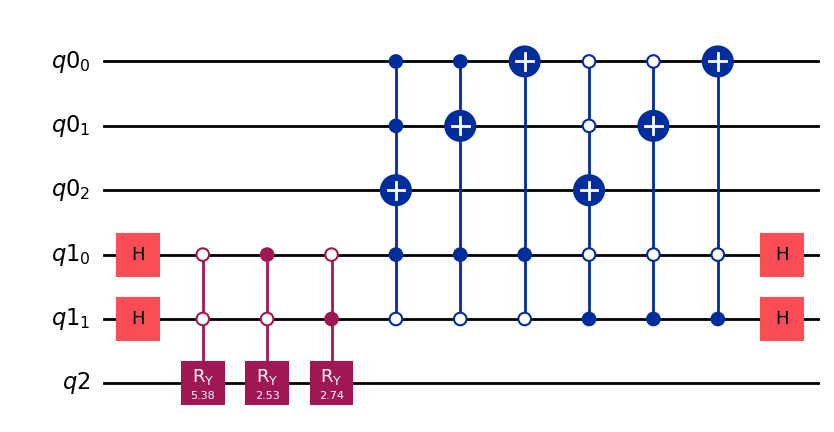

In [11]:
circuit_drawer(qc, output='mpl', filename='banded_circulant.png')

In [12]:
qc.save_unitary()

simulator = Aer.get_backend('aer_simulator')
compiled = transpile(qc, simulator)
result = simulator.run(compiled).result()
unitary = result.get_unitary(compiled)
block_size = 2 ** len(qreg_j)
top_left_block = np.round(np.asarray(unitary)[:block_size, :block_size], 4)

A_scaled = np.round(A / 4, 4)  # Since s = 4
print("\nBlock-Encoded Top-Left Block (A / s):")
print(np.real(top_left_block))
print("\nExpected A / 4:")
print(A_scaled)


Block-Encoded Top-Left Block (A / s):
[[0.025 0.05  0.    0.    0.    0.    0.    0.075]
 [0.075 0.025 0.05  0.    0.    0.    0.    0.   ]
 [0.    0.075 0.025 0.05  0.    0.    0.    0.   ]
 [0.    0.    0.075 0.025 0.05  0.    0.    0.   ]
 [0.    0.    0.    0.075 0.025 0.05  0.    0.   ]
 [0.    0.    0.    0.    0.075 0.025 0.05  0.   ]
 [0.    0.    0.    0.    0.    0.075 0.025 0.05 ]
 [0.05  0.    0.    0.    0.    0.    0.075 0.025]]

Expected A / 4:
[[0.025 0.05  0.    0.    0.    0.    0.    0.075]
 [0.075 0.025 0.05  0.    0.    0.    0.    0.   ]
 [0.    0.075 0.025 0.05  0.    0.    0.    0.   ]
 [0.    0.    0.075 0.025 0.05  0.    0.    0.   ]
 [0.    0.    0.    0.075 0.025 0.05  0.    0.   ]
 [0.    0.    0.    0.    0.075 0.025 0.05  0.   ]
 [0.    0.    0.    0.    0.    0.075 0.025 0.05 ]
 [0.05  0.    0.    0.    0.    0.    0.075 0.025]]


#### The success probability for the above block encoding circuit is $(\frac{||A\ket{x}||}{4})^2= \frac{||A\ket{x}||^2}{16}$. Three ancilla qubits are needed for this irrespective of the matrix size.

___

Expected success probability (||A|x>||/4)^2 = 0.008750
Measured ancilla counts (summary): {'110': 1335, '100': 1233, '001': 2352, '101': 1327, '000': 90, '010': 2331, '011': 90, '111': 1242}
Interpreting ancilla all-zeros (000) as 'success'. Measured success probability = 0.0090 (90/10000)


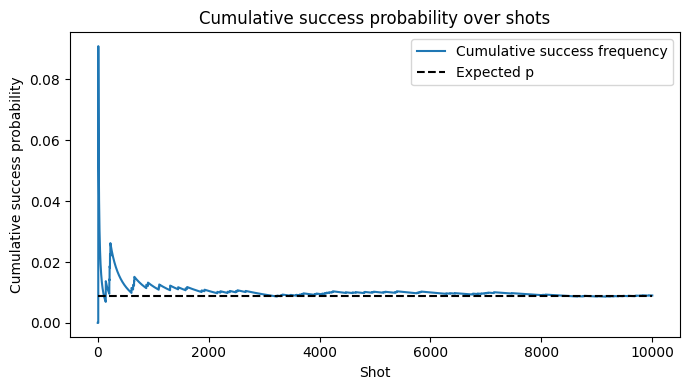


Summary:
  Expected success probability = 0.008750
  Measured success probability  = 0.009000 (all-ancilla zeros)
  Shots = 10000


In [17]:
# Define input state |x> = |0...0> (computational zero state)
n = N  # uses N defined earlier in the notebook
x = np.zeros((n, 1))
x[0, 0] = 1.0

# Compute A|x> and expected success probability p = (||A|x>|| / s)^2 with s=4
Ax = A.dot(x).flatten()
expected_p = (np.linalg.norm(Ax) / 4.0) ** 2
print(f"Expected success probability (||A|x>||/4)^2 = {expected_p:.6f}")

# Build a fresh circuit that implements the same block-encoding and measures ALL ancilla qubits
# Note: success is defined as all ancilla qubits (qreg_l and qreg_anc) being '0'
qreg_j = QuantumRegister(int(log2(N)), 'j')
qreg_l = QuantumRegister(num_controls, 'l')
qreg_anc = QuantumRegister(1, 'anc')
# classical register sized to hold all ancilla measurement bits
creg = ClassicalRegister(num_controls + 1, 'c_anc_all')
qc_sample = QuantumCircuit(qreg_j, qreg_l, qreg_anc, creg)
apply_block_encoding_circuit(qc_sample, qreg_l, qreg_anc, qreg_j, theta_raw)
# Measure all ancilla qubits into the classical register: qreg_l[0..] then qreg_anc[0]
for i in range(num_controls):
    qc_sample.measure(qreg_l[i], creg[i])
qc_sample.measure(qreg_anc[0], creg[num_controls])

# Run shots and collect memory (per-shot outcomes) to produce cumulative plot
shots = 10000
sim = Aer.get_backend('aer_simulator')
compiled = transpile(qc_sample, sim)
job = sim.run(compiled, shots=shots, memory=True)
result = job.result()
memory = result.get_memory(compiled)  # list of bitstrings (e.g. '000')
counts = result.get_counts(compiled)
# Define success as the all-zero ancilla bitstring (length = num_controls + 1)
success_bitstring = '0' * (num_controls + 1)
success_count = counts.get(success_bitstring, 0)
success_prob = success_count / shots
print(f"Measured ancilla counts (summary): {counts}")
print(f"Interpreting ancilla all-zeros ({success_bitstring}) as 'success'. Measured success probability = {success_prob:.4f} ({success_count}/{shots})")

# Cumulative success frequency across shots (convergence visualization)
# memory entries are bitstrings corresponding to the classical register `c_anc_all`
success_array = np.array([1 if m == success_bitstring else 0 for m in memory], dtype=int)
cum_success = np.cumsum(success_array) / np.arange(1, shots + 1)
plt.figure(figsize=(7,4))
plt.plot(cum_success, label='Cumulative success frequency')
plt.hlines(expected_p, 0, shots - 1, colors='k', linestyles='--', label='Expected p')
plt.xlabel('Shot')
plt.ylabel('Cumulative success probability')
plt.title('Cumulative success probability over shots')
plt.legend()
plt.tight_layout()
plt.show()

# Small summary printed for clarity
print('\nSummary:')
print(f'  Expected success probability = {expected_p:.6f}')
print(f'  Measured success probability  = {success_prob:.6f} (all-ancilla zeros)')
print(f'  Shots = {shots}')

___